In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tifffile as tf
from keras.models import load_model
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.filters import gaussian
from scipy import histogram
from skimage.filters import threshold_otsu
from fast_histogram import histogram1d
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb

Using TensorFlow backend.


In [10]:
import tifffile as tf
from matplotlib import pyplot as plt
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks

In [2]:
def auto_canny(image,sigma= 0.13):
    
    #Use the median to determine the lower and upper thresholds for canny.
    #The median is less sensitive to outliers than the average, as it is has no knowledge of individual values just their order in size
    
    median = np.median(image)
    
    lower = int(max(0,(1.0-sigma)*median))
    upper = int(min(np.max(image),(1.0+sigma)*median))
    
    
    edged = canny(image,sigma = 3,low_threshold=lower,high_threshold=upper)
    
    return edged

In [3]:
with tf.TiffFile('/Users/MarcusF/Desktop/TrapAnalysis/260522_CecB-  PCPG vesicles- after flushing_1_MMStack_Pos6.ome.tif') as tif:
    images = tif.asarray()

/Users/MarcusF/anaconda3/lib/python3.6/site-packages/tifffile/tifffile.py:2236: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn('ome-xml: not an ome-tiff master file')


In [5]:
image = images[0]

In [8]:
help(histogram1d)

Help on function histogram1d in module fast_histogram.histogram:

histogram1d(x, bins, range, weights=None)
    Compute a 1D histogram assuming equally spaced bins.
    
    Parameters
    ----------
    x : `~numpy.ndarray`
        The position of the points to bin in the 1D histogram
    bins : int
        The number of bins
    range : iterable
        The range as a tuple of (xmin, xmax)
    weights : `~numpy.ndarray`
        The weights of the points in the 1D histogram
    
    Returns
    -------
    array : `~numpy.ndarray`
        The 1D histogram array



In [6]:
low_pass_image = gaussian(image,2,preserve_range=True)

In [6]:
%matplotlib qt


In [21]:
plt.imshow(low_pass_image)

In [7]:
low_pass_clip = low_pass_image[295:320,175:200]

In [23]:
plt.imshow(low_pass_clip)

In [8]:
clip = image[295:320,175:200]

In [25]:
plt.imshow(clip)

In [9]:
plt.figure()
plt.plot(clip[15,:],c = 'r')
plt.plot(low_pass_clip[15,:], c= 'k')

In [9]:
subtracted_clip= clip[15,:]-low_pass_clip[15,:]

In [31]:
plt.plot(subtracted_clip)

In [10]:
scale_factor = clip[15,4]/low_pass_clip[15,4]

In [11]:
scaled_low_pass = scale_factor*low_pass_image


In [12]:
filtered_image = image-scaled_low_pass

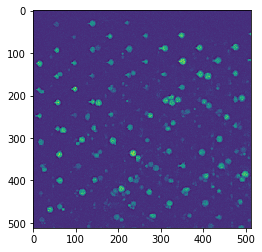

In [13]:
plt.imshow(filtered_image)

In [16]:
threshold = threshold_otsu(filtered_image)

In [17]:
mask = np.zeros_like(image)

In [18]:
mask[filtered_image > threshold+1] = 1


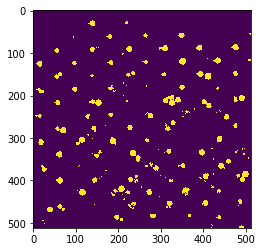

In [19]:
plt.imshow(mask)

In [20]:
from scipy.ndimage import distance_transform_edt

In [21]:
distance_map = distance_transform_edt(mask)

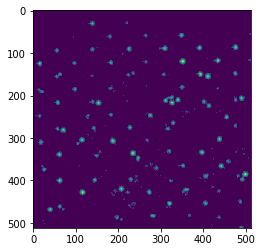

In [22]:
plt.imshow(distance_map)

In [24]:
dy,dx = histogram(distance_map[distance_map >0].flatten(),10)

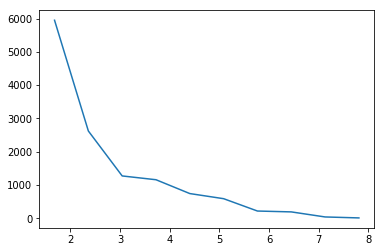

In [25]:
plt.plot(dx[1:],dy)

In [26]:
from skimage.feature import peak_local_max

In [33]:
peaks = peak_local_max(distance_map,threshold_abs=3,min_distance=4)

In [34]:
peaks

array([[488, 197],
       [487, 197],
       [486, 437],
       [483, 282],
       [481, 367],
       [468,  40],
       [461,  62],
       [454, 405],
       [454, 320],
       [450, 487],
       [428, 222],
       [428, 116],
       [427, 272],
       [427, 221],
       [427, 116],
       [424, 436],
       [421, 359],
       [421, 358],
       [419, 207],
       [401, 323],
       [400,  62],
       [399, 145],
       [398, 230],
       [397, 491],
       [397, 230],
       [397, 229],
       [396, 229],
       [390, 406],
       [390, 405],
       [389, 481],
       [389, 480],
       [385, 498],
       [374,  26],
       [371, 289],
       [370, 289],
       [366, 442],
       [365, 353],
       [365, 352],
       [364, 352],
       [355, 458],
       [346, 247],
       [342, 148],
       [339,  61],
       [336, 234],
       [334, 396],
       [333, 396],
       [331, 320],
       [330, 319],
       [313, 105],
       [310,  18],
       [307, 187],
       [305, 268],
       [305,

(<matplotlib.image.AxesImage at 0x1c35dea710>,
 <matplotlib.collections.PathCollection at 0x1c35e3c320>)

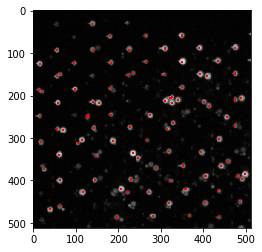

In [35]:
plt.imshow(image,zorder = 1,cmap = 'gray'),plt.scatter(peaks[:,1],peaks[:,0],marker = '+',s = 4,c = 'r',zorder = 2)

In [55]:
sum_of_edges = np.zeros_like(images[0])
for image in images[130:140]:
    edgemap = auto_canny(image)
    sum_of_edges += edgemap
    
plt.imshow(sum_of_edges)

In [6]:
%matplotlib qt


In [59]:
plt.imshow(sum_of_edges)

In [66]:
hough_radii = np.arange(4,8)
hough_res = hough_circle(sum_of_edges,hough_radii)

accumms,cx,cy,radii = hough_circle_peaks(hough_res,hough_radii,min_xdistance=15,min_ydistance=15)

In [67]:
radii.shape


(238,)

In [68]:
image = images[0]
image = image/np.max(image)

In [69]:
rgbimg = gray2rgb(image)

In [70]:
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,shape = rgbimg.shape)
    rgbimg[circy, circx] = (220, 20, 20)

In [72]:
plt.imshow(rgbimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [48]:
plt.figure()
plt.subplot(211)
plt.imshow(rgbimg)
plt.subplot(212)
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
